<a href="https://colab.research.google.com/github/YY535/LFP_Simulation/blob/main/LFPy_simple_example_CA1pyr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install LFPy
!wget https://raw.githubusercontent.com/YY535/LFP_Simulation/main/EB1-early-bifurcation.swc
# !wget https://raw.githubusercontent.com/LFPy/LFPy/master/examples/morphologies/L5_Mainen96_LFPy.hoc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for LFPy: filename=LFPy-2.3-cp310-cp310-linux_x86_64.whl size=588232 sha256=02e469228c974170d1eabca8b087d442f0f31764705f9f254c7c25ef509bb000
  Stored in directory: /root/.cache/pip/wheels/3b/dc/6b/6c4698fb3cb6890f82d630f522f7d8410abea920f276532cdb
Successfully built LFPy
--2023-06-21 15:02:19--  https://raw.githubusercontent.com/LFPy/LFPy/master/examples/morphologies/L5_Mainen96_LFPy.hoc
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to

# simulation

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import LFPy
from LFPy import Cell, Synapse, LineSourcePotential
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Create the cell, synapse and electrode ojects using the LFPy.Cell, LFPy.Synapse, LFPy.RecExtElectrode classes.

In [15]:
cellParameters = {
    'morphology': '/content/EB1-early-bifurcation.swc',
    'tstart': -50,
    'tstop': 60,
    'dt': 2**-4,
    'passive': True,
}

synapseParameters = {
    'syntype': 'Exp2Syn',
    'e': 0.,
    'tau1': 0.5,
    'tau2': 2.0,
    'weight': 0.005,
    'record_current': True,
}

z = np.mgrid[-300:501:25]
electrodeParameters = {
    'x': np.zeros(z.size),
    'y': np.zeros(z.size),
    'z': z,
    'sigma': 0.3,
}


Creat cell, define and then connect the synapses

In [18]:
cell = LFPy.Cell(**cellParameters)
cell.set_rotation(x=np.pi/2, y=0., z=0.)
sec_n = cell.get_rand_idx_area_norm(nidx = 20, z_min = 200, z_max = 300)
print(sec_n)
synapses = []
for idxes in sec_n:
  synapse = LFPy.Synapse(cell,
                       idx = idxes,
                       **synapseParameters)
  synapse.set_spike_times(np.array([10, 30, 50]))
  synapses.append(synapse)


synapses2 = []
sec_n2 = cell.get_rand_idx_area_norm(nidx = 10, z_min = 100, z_max = 200)
dts = 1
synapses2 = []
for idxes in sec_n2:
  synapse = LFPy.Synapse(cell,
                       idx = idxes,
                       **synapseParameters)
  synapse.set_spike_times(np.array([20, 30+dts, 50-dts]))
  synapses2.append(synapse)


[245 276 222 228 264 221 234 224 279 266 264 262 262 253 232 223 264 232
 255 259]
[133 217 149 204 212 215 217 211 118 212]


In [19]:
lsp = LineSourcePotential(cell=cell,**electrodeParameters) # use linesource approximation of LFP

Run Simulation

In [20]:
cell.simulate(probes=[lsp],rec_imem=True) #

Text(0.5, 0, 'time (ms)')

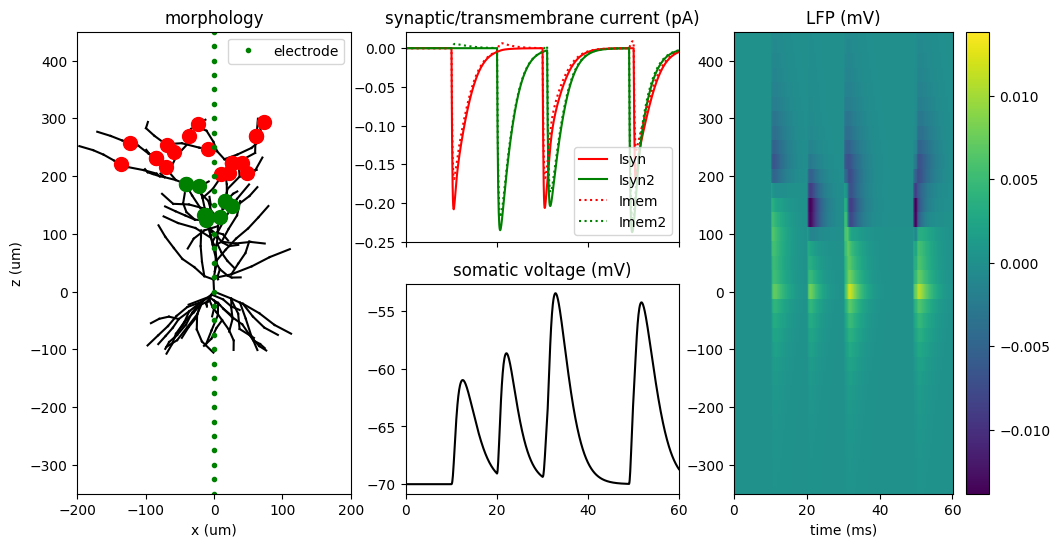

In [28]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3)

ax0 = fig.add_subplot(gs[:, 0])
ax0.plot(cell.x.T, cell.z.T, 'k')
for synapse in synapses:
  ax0.plot(synapse.x, synapse.z,
          color='r', marker='o', markersize=10)
for synapse2 in synapses2:
  ax0.plot(synapse2.x, synapse2.z,
          color='g', marker='o', markersize=10)
ax0.plot(lsp.x, lsp.z, '.', color='g',
        label='electrode')
ax0.axis([-200, 200, -350, 450])
ax0.legend()
ax0.set_xlabel('x (um)')
ax0.set_ylabel('z (um)')
ax0.set_title('morphology')

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(cell.tvec, synapses[0].i, color='r',label='Isyn')
ax1.plot(cell.tvec, synapses2[0].i, color='g',label='Isyn2')
ax1.plot(cell.tvec, cell.imem[sec_n[0]],':', color='r',label='Imem')
ax1.plot(cell.tvec, cell.imem[sec_n2[0]],':', color='g',label='Imem2')
ax1.set_title('synaptic/transmembrane current (pA)')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend()

ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax2.plot(cell.tvec, cell.somav, 'k')
ax2.set_title('somatic voltage (mV)')

ax3 = fig.add_subplot(gs[:, 2], sharey=ax0, sharex=ax1)
im = ax3.pcolormesh(cell.tvec, lsp.z, lsp.data,
                 vmin=-abs(lsp.data).max(), vmax=abs(lsp.data).max(),
                 shading='auto')
plt.colorbar(im)
ax3.set_title('LFP (mV)')
ax3.set_xlabel('time (ms)')

#savefig('LFPy-example-two_inputs.pdf', dpi=300)

In [29]:
!pip install git+https://github.com/Neuroinflab/kCSD-python.git


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Neuroinflab/kCSD-python.git to /tmp/pip-req-build-4sdjabuj
  Running command git clone --filter=blob:none --quiet https://github.com/Neuroinflab/kCSD-python.git /tmp/pip-req-build-4sdjabuj
  Resolved https://github.com/Neuroinflab/kCSD-python.git to commit de7fd0c4a99b69935a0c06aef1be7f68426e7d69
  Preparing metadata (setup.py) ... done
  Created wheel for kcsd: filename=kcsd-2.0-py3-none-any.whl size=61923 sha256=b9c1ff46bd9a0b7a6ed6aa65860d335747e28741e2dfbee6687c9752f10bdd35
  Stored in directory: /tmp/pip-ephem-wheel-cache-pyjs9kbj/wheels/d5/e0/a8/d49b638f9a01680975038458bf3db35c83ded74b01910be0e6
Successfully built kcsd


In [31]:
from kcsd import KCSD1D

def do_kcsd(ele_pos, pots):
    h = 50.  # distance between the electrode plane and the midslice
    sigma = 1.0 # S/m
    ele_pos = ele_pos.reshape((len(ele_pos), 1))
    pots = pots.reshape((len(ele_pos), -1)) # first time point
    k = KCSD1D(ele_pos, pots, h=h, sigma=sigma,
               xmin=ele_pos.min(), xmax=ele_pos.max(),
               n_src_init=100, src_type='gauss', R_init=10.)
    return k


k = do_kcsd(lsp.z, lsp.data)
est_csd = k.values('CSD')

Text(0.5, 0, 'time (ms)')

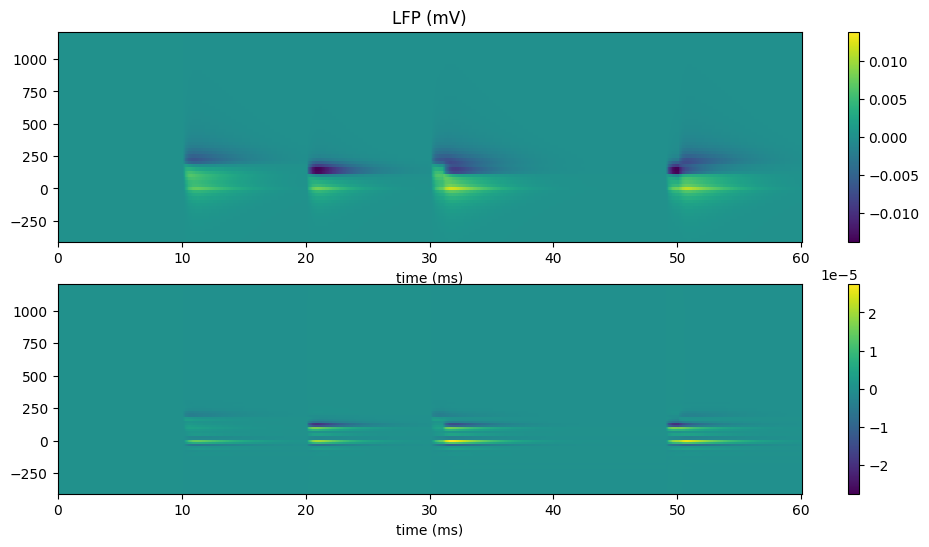

In [32]:
fig_csd = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 1)

ax0 = fig_csd.add_subplot(gs[0,:])
im = ax0.pcolormesh(cell.tvec, lsp.z, lsp.data,
                 vmin=-abs(lsp.data).max(), vmax=abs(lsp.data).max(),
                 shading='auto')
plt.colorbar(im)
ax0.set_title('LFP (mV)')
ax0.set_xlabel('time (ms)')

ax1 = fig_csd.add_subplot(gs[1,:], sharex=ax0)
im_csd = ax1.pcolormesh(cell.tvec, k.estm_x, est_csd,
                 vmin=-abs(est_csd).max(), vmax=abs(est_csd).max(),
                 shading='auto')
plt.colorbar(im_csd)
ax1.set_title('')
ax1.set_xlabel('time (ms)')

In [35]:
lsp.data.shape

(65, 961)

In [33]:
k.cross_validate(Rs=np.linspace(5, 30, 5))
est_csd = k.values('CSD')

No lambda given, using defaults
Cross validating R (all lambda) : 5.0
Cross validating R (all lambda) : 11.25


KeyboardInterrupt: ignored

Text(0.5, 0, 'time (ms)')

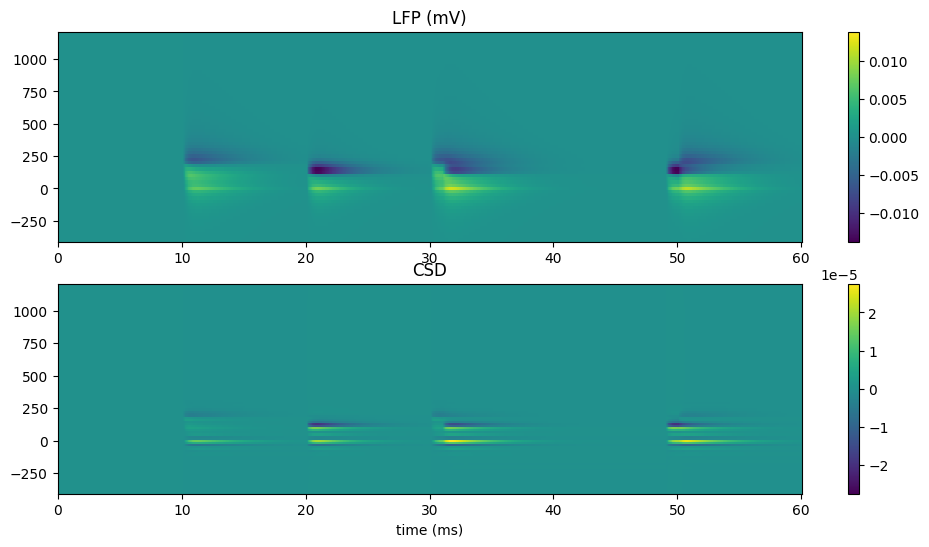

In [40]:
fig_csdopt = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 1)

ax0 = fig_csdopt.add_subplot(gs[0,:])
im = ax0.pcolormesh(cell.tvec, lsp.z, lsp.data,
                 vmin=-abs(lsp.data).max(), vmax=abs(lsp.data).max(),
                 shading='auto')
plt.colorbar(im)
ax0.set_title('LFP (mV)')

ax1 = fig_csdopt.add_subplot(gs[1,:], sharex=ax0)
im_csd = ax1.pcolormesh(cell.tvec, k.estm_x, est_csd,
                 vmin=-abs(est_csd).max(), vmax=abs(est_csd).max(),
                 shading='auto')

plt.colorbar(im_csd)
ax1.set_title('CSD')
ax1.set_xlabel('time (ms)')